In [2]:
import matplotlib.pyplot as plt
import numpy as np

from model import StaticParticle, CylinderDetector, Detector
from joblib import Parallel, delayed

In [3]:
particle = StaticParticle()
particle.set_position_cylindrical(r=0.1, theta=0, z=0.1)

detector = CylinderDetector()

## Finding an emission with Compton Scattering

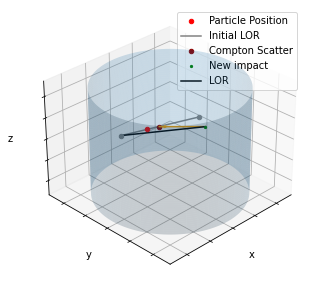

In [9]:
from IPython.display import clear_output
while True:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')

    impacts, n_scatters = particle.simulate_emissions(detector=detector, n_emissions=1, debug_ax=ax)

    if n_scatters != 1:  # Make sure one did occur
        plt.figure().clear()
        plt.close()
        plt.cla()
        plt.clf()
        continue
        
    clear_output(wait=False)

    R, H = detector.dim_radius_cm, detector.dim_height_cm
    ax.axes.set_xlim3d(left=-0.01-R, right=0.01+R)
    ax.axes.set_ylim3d(bottom=-0.01-R, top=0.01+R)
    ax.axes.set_zlim3d(bottom=-0.01-H/2, top=H/2 + 0.01)

    ax.set_xlabel("x", labelpad=0)
    ax.set_ylabel("y", labelpad=0)
    ax.set_zlabel("z", labelpad=0)

    ax.tick_params(labelleft=False, labelright=False, labelbottom=False)
    # plt.title('Static Radioactive Particle in Cylinder Detector')
    ax.view_init(azim=45, elev=30)
    detector.debug_plot(ax=ax)
    plt.legend()
    plt.savefig('figures/one_scatter_diagram.png', transparent=True)
    plt.show()
    break

## Compare LoR detection rate against scattering rate (debugging)

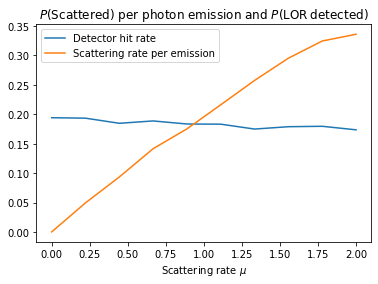

In [10]:
def plot_2_experiment(detector: Detector, scatter_rate=2.0, n_emissions=10000):
    p = StaticParticle(scatter_rate=scatter_rate)
    p.set_position_cartesian(0, 0, 0.2)
    lors, n_impacts = p.simulate_emissions(detector=detector, n_emissions=n_emissions)

    # Detector hit rate overall from n_lor emissions, Scattering rate given detector hit
    return len(lors)/n_emissions, n_impacts/(2.0*len(lors))


rates = np.linspace(start=0.001, stop=2.0, num=10)
prop = np.array([plot_2_experiment(detector=detector, scatter_rate=r) for r in rates])
plt.figure()
plt.plot(rates, prop[:, 0], label='Detector hit rate')
plt.plot(rates, prop[:, 1], label='Scattering rate per emission')
plt.xlabel(r'Scattering rate $\mu$')
plt.title(r'$P(\mathrm{Scattered})$ per photon emission and $P(\mathrm{LOR\:detected})$')
plt.legend()
plt.show()

## Detector hit rate as a function of particle position

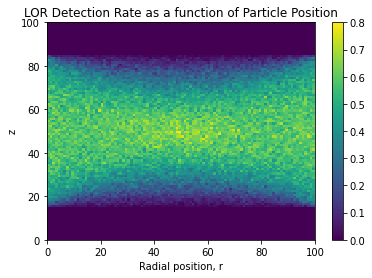

In [11]:
def plot_3_sample_hit_rate(detector: Detector, r: float, z: float, n_emissions=100):
    p = StaticParticle()
    p.set_position_cylindrical(r=r, theta=0.0, z=z)
    lors, _ = p.simulate_emissions(detector=detector, n_emissions=n_emissions)
    return len(lors)/n_emissions


N = 100
r = np.linspace(start=-detector.dim_radius_cm+0.01, stop=detector.dim_radius_cm-0.01, num=N)
z = np.linspace(start=-0.1-detector.dim_height_cm/2.0, stop=detector.dim_height_cm/2.0+0.1, num=N)

rr, zz = np.meshgrid(r, z, indexing='ij')
hit_rate = Parallel(n_jobs=-1)(delayed(plot_3_sample_hit_rate)(detector, rr[i, j], zz[i, j]) for j in range(N) for i in range(N))
hit_rate = np.array(hit_rate).reshape((N, N))
# h = plt.contourf(r, z, hit_rate)
plt.pcolormesh(hit_rate)
plt.title('LOR Detection Rate as a function of Particle Position')
plt.xlabel('Radial position, r')
plt.ylabel('z')
plt.colorbar()
plt.show()

## Debugging LoR detection rate symmetry along z-axis for particle at x=0.0, y=0.0

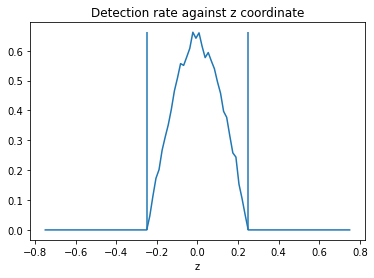

In [20]:
def plot_4_sample_hit_rate(z=0.0):
    p = StaticParticle()
    p.set_position_cylindrical(r=0.0, theta=0.0, z=z)
    
    n_emissions=1000
    lors, _ = p.simulate_emissions(detector=detector, n_emissions=n_emissions)
    return len(lors)/n_emissions


H = detector.dim_height_cm
zz = np.linspace(-0.5-H/2, H/2+0.5, 100)
hit_rates = Parallel(n_jobs=-1)(delayed(plot_4_sample_hit_rate)(z) for z in zz)
plt.vlines([-H/2, H/2], ymin=0.0, ymax=max(hit_rates))
plt.plot(zz, hit_rates)
plt.title('Detection rate against z coordinate')
plt.xlabel('z')
plt.show()

## Individual cell hit rate plotted for different particle positions

Statistics 53380 66099 0.40378825700842674


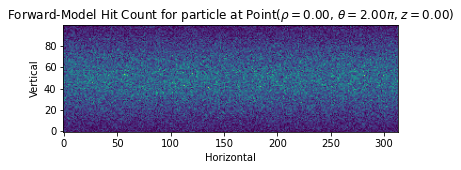

Statistics 42561 59011 0.36061920658860214


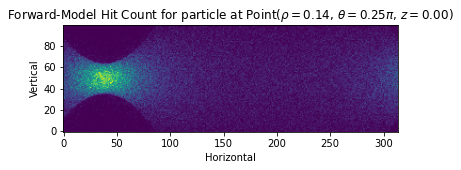

Statistics 21601 31823 0.3393928919335072


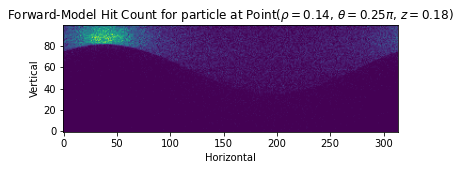

In [23]:
def plot_5(particle: StaticParticle, use_multicore=True):
    d = CylinderDetector()
    n_phi, n_z = d.n_detector_cells()
    cells_hit_counts = np.zeros(shape=d.n_detector_cells(), dtype=int)

    if use_multicore:
        n_batches = 10
        n_lor = 10000
        sims = Parallel(n_jobs=-1)(delayed(p.simulate_emissions)(detector=d, n_emissions=n_lor) for _ in range(n_batches))
        lors, scatters = sum([sim[0] for sim in sims], []), sum([sim[1] for sim in sims])
    else:
        lors, scatters = p.simulate_emissions(detector=d, n_emissions=10000)

    if len(lors) > 0:
        print('Statistics', scatters, len(lors), scatters/(2*len(lors)))
        scatter_rate = scatters/(2*len(lors))
    else:
        print('No LoRs')

    for lor in lors:
        i, j = lor
        cells_hit_counts[i % n_phi, i // n_phi] += 1
        cells_hit_counts[j % n_phi, j // n_phi] += 1

    plt.imshow(cells_hit_counts.transpose(), origin='lower')
    plt.title(fr'Forward-Model Hit Count for particle at {p.to_str_cylindrical(latex=True)}')
    plt.xlabel('Horizontal')
    plt.ylabel('Vertical')
    plt.show()


p = StaticParticle()
p.scatter_rate = 2.0  # Arbitrary

plot_5(p)

p.set_position_cartesian(0.1, 0.1, 0.0)
plot_5(p)

p.set_position_cartesian(0.1, 0.1, 0.18)
plot_5(p)